In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import random 
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
PATH = './'
TRAIN = './train/'
TEST = './test/'
LABELS = './TRAIN.csv'

MOREDATA = './moredata/'
MORELABELS = './HPAv18RBGY_wodpl.csv'

SAMPLE = './sample_submission.csv'

In [4]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [6]:
train = pd.read_csv('train.csv')
moredata = pd.read_csv(MORELABELS)

In [9]:
#train['Target']=[[int(i) for i in s.split()]  for s in train['Target']]
#moredata['Target']=[[int(i) for i in s.split()]  for s in moredata['Target']]

reverse_train_labels = dict((v,k) for k,v in name_label_dict.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = name_label_dict[int(num)]
        row.loc[name] = 1
    return row

for key in name_label_dict.keys():
    train[name_label_dict[key]] = 0

train = train.apply(fill_targets, axis=1)

"""
for key in name_label_dict.keys():
    moredata[name_label_dict[key]] = 0

moredata = moredata.apply(fill_targets, axis=1)
"""

'\nfor key in name_label_dict.keys():\n    moredata[name_label_dict[key]] = 0\n\nmoredata = moredata.apply(fill_targets, axis=1)\n'

In [10]:
target_counts = train.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
drop_list = [reverse_train_labels[i] for i in target_counts[-14:].keys()]

In [11]:
moredata = pd.read_csv(MORELABELS)
moredata['Target']=[[int(i) for i in s.split()]  for s in moredata['Target']]
#for i in range(len(moredata)):
#    if moredata[i]

In [12]:
drop = []
for inum in range(len(moredata['Id'])):
    for i in moredata['Target'][inum]:
        if i in drop_list:
            drop.append(inum)
            continue
moredata = pd.read_csv(MORELABELS)    
pd.DataFrame({'Id':moredata['Id'][drop],'Target':moredata['Target'][drop]}).to_csv('rare.csv', header=True, index=False)

In [5]:
moredata_names = list(pd.read_csv(MORELABELS)['Id'])
train_names = sorted({f[:36] for f in os.listdir(TRAIN)})
test_names = sorted({f[:36] for f in os.listdir(TEST)})
print('train:',len(train_names),'  test:',len(test_names))
tr_n,val_n = train_test_split(train_names, test_size=0.05, random_state=seed)
tr_n += moredata_names
print('train:',len(tr_n),'  val:',len(val_n))

train: 74606   test: 11702
train: 70875   val: 3731


In [6]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      1,1,1,1,2,1,1,1,
                      1,1,1,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,LABELS))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

72597


In [7]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE

    try:
        img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    except:
        #print(id)
        img = [cv2.imread(os.path.join(MOREDATA, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    return np.stack(img, axis=-1)

In [8]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [9]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    # Iafoss original RGBY
    #stats = A([0.0804, 0.0526, 0.0547, 0.0827], [0.394, 0.321, 0.327, 0.399])
    # HPAv18 all RGBY (each image is colored RGB png image 512x512)
    stats = A([0.06734, 0.05087, 0.03266, 0.09257],[0.11997, 0.10335, 0.10124, 0.1574 ])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [14]:
nw = 2   #number of workers for data loader
arch = resnet50 #specify target architecture

bs = 16
sz = 256
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 28]))

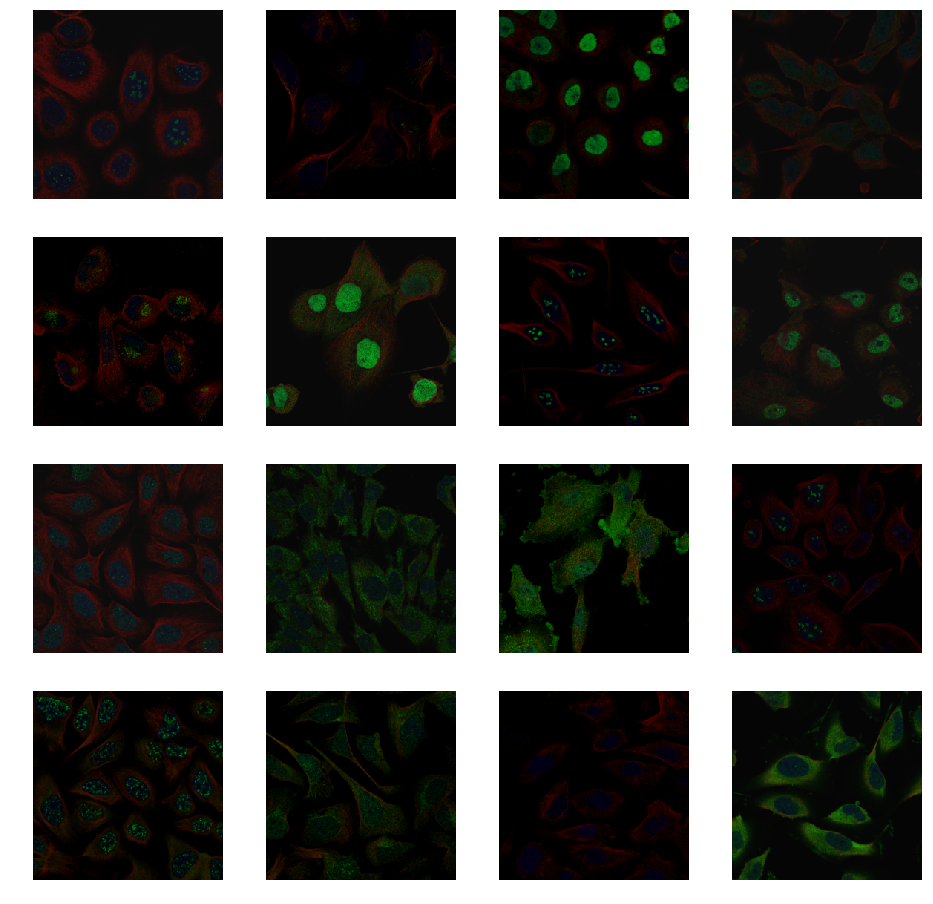

In [11]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [12]:
"""
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in tqdm(iter(md.trn_dl)):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std
"""

'\nx_tot = np.zeros(4)\nx2_tot = np.zeros(4)\nfor x,y in tqdm(iter(md.trn_dl)):\n    tmp =  md.trn_ds.denorm(x).reshape(16,-1)\n    x = md.trn_ds.denorm(x).reshape(-1,4)\n    x_tot += x.mean(axis=0)\n    x2_tot += (x**2).mean(axis=0)\n\nchannel_avr = x_tot/len(md.trn_dl)\nchannel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)\nchannel_avr,channel_std\n'

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [11]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [12]:
class F1:
    __name__ = 'F1 macro'
    def __init__(self,n=28):
        self.n = n
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        #print('F1:',score)
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

In [15]:
from newConvLearner import ConvLearner

sz = 512 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.models.model = torch.nn.DataParallel(learner.models.model,device_ids=[0, 1])
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
f1_callback = F1_callback()
learner.metrics = [acc,f1_callback.f1]
learner.summary

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


<bound method ConvLearner.summary of DataParallel(
  (module): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequent

In [17]:
"""
learner.lr_find()
learner.sched.plot()
"""

'\nlearner.lr_find()\nlearner.sched.plot()\n'

In [16]:
learner.load('ResNet50_512_1')

In [18]:
lr = 0.5e-2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr,1,callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

  0%|          | 1/2268 [00:03<2:30:03,  3.97s/it, loss=9.99]

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                          
    0      1.250424   8.290174   0.944184  



[8.290174469779114, 0.944183906947151]

In [19]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

  0%|          | 0/2268 [00:00<?, ?it/s]

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                           
    0      0.888085   16.546472  0.961893  
    1      0.789875   33.888096  0.96374                       
    2      0.816558   150.589053 0.958399                      
    3      0.738064   41.346902  0.964803                      
    4      0.786084   42.821374  0.960629                      
    5      0.713713   30.452154  0.968641                      
    6      0.76442    30.021876  0.963022                      
    7      0.710564   3.789704   0.969378                      



[3.7897042442154096, 0.9693782233865994]

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/16,2,cycle_len=4,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

  0%|          | 0/2268 [00:00<?, ?it/s]

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                           
    0      0.758637   146.349964 0.956838  
    1      0.746815   67.793733  0.964381                      
    2      0.716115   24.695189  0.965616                      
    3      0.67946    18.908981  0.96599                       
    4      0.76346    34.615553  0.963233                      
    5      0.707782   20.404817  0.965253                      
    6      0.700661   11.903653  0.968134                      
    7      0.669336   5.803636   0.969139                      



[5.803635696037562, 0.9691389181025384]

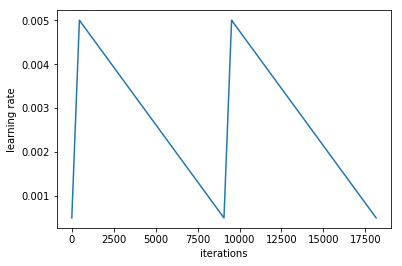

In [22]:
learner.sched.plot_lr()

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/32,1,cycle_len=8,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

  0%|          | 0/2268 [00:00<?, ?it/s]

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                           
    0      0.691667   3.762477   0.970039  
    1      0.678176   4.934567   0.970115                      
    2      0.675229   6.486638   0.969455                      
    3      0.660466   3.723345   0.971781                      
    4      0.669045   1.554215   0.971896                      
    5      0.65847    1.374266   0.970833                      
    6      0.640449   0.701812   0.972441                      
    7      0.65188    1.012337   0.972403                      



[1.0123369684809815, 0.972403073528119]

In [24]:
learner.save('ResNet50_512_2')

In [17]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [18]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [19]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [0.50793 0.52615 0.54675 0.47583 0.48101 0.4774  0.47393 0.50145 0.6208  0.49923 0.83543 0.47316 0.57595
 0.40892 0.53616 0.5     0.35018 0.37437 0.41382 0.49566 0.41567 0.48095 0.44001 0.47661 0.1     0.46955
 0.41846 0.54672]
F1 macro:  0.4908621346860099
F1 macro (th = 0.5):  0.45442835099604295
F1 micro:  0.6928487690504103


/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [20]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.38917 0.02198 0.07531 0.02734 0.04449 0.03243 0.03538 0.07719 0.0059  0.00456 0.00054 0.00992 0.01635
 0.00965 0.02064 0.00295 0.01635 0.00241 0.00884 0.01983 0.00777 0.10855 0.02064 0.09542 0.16859 0.4476
 0.00295 0.00241]
Fractions (true):  [0.37631 0.0268  0.0981  0.02975 0.04744 0.03994 0.04101 0.09006 0.00161 0.0008  0.00134 0.01635 0.02117
 0.00992 0.02171 0.      0.00992 0.00429 0.01206 0.02519 0.00295 0.1241  0.02439 0.09783 0.00241 0.39426
 0.00482 0.00107]


In [21]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [22]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [23]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.05734 0.03162 0.00692 0.13972 0.09913 0.08716 0.2039  0.03179 0.00393 0.00034 0.00051 0.04598 0.0441
 0.01256 0.06802 0.00017 0.05426 0.00615 0.00385 0.03418 0.07383 0.03136 0.02401 0.05529 0.00009 0.12271
 0.00188 0.36344]


In [24]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [25]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [26]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.29936 0.31633 0.34836 0.45635 0.36805 0.41363 0.49489 0.37675 0.2633  0.16834 0.19193 0.43196 0.31997
 0.36483 0.60444 0.17539 0.44168 0.36129 0.34745 0.33956 0.51172 0.3607  0.3581  0.43209 0.23909 0.48143
 0.20724 0.53245]
Fractions:  [0.36062 0.04222 0.06495 0.05657 0.0699  0.07136 0.04196 0.06631 0.00889 0.00701 0.00752 0.04213 0.04127
 0.01384 0.04392 0.00701 0.02726 0.01333 0.0247  0.0558  0.00769 0.11904 0.02666 0.07247 0.00248 0.2186
 0.01897 0.00949]
Fractions (th = 0.5):  [0.09913 0.02128 0.01265 0.03957 0.02581 0.03256 0.03939 0.02068 0.00205 0.00017 0.      0.02427 0.0135
 0.00709 0.06503 0.00017 0.01085 0.00325 0.00154 0.01675 0.00983 0.03239 0.00897 0.04375 0.00009 0.18963
 0.      0.01162]


In [27]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [28]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [29]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [30]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([28073.,  1818.,  7250.,  1768.,  3272.,  3425.,  2717.,  6583.,   164.,   152.,   154.,  1101.,
         1545.,   921.,  1626.,    42.,   760.,   236.,   991.,  2190.,   266., 10032.,  1927.,  7380.,
          106., 29138.,   378.,   116.]),
 array([0.37628, 0.02437, 0.09718, 0.0237 , 0.04386, 0.04591, 0.03642, 0.08824, 0.0022 , 0.00204, 0.00206,
        0.01476, 0.02071, 0.01234, 0.02179, 0.00056, 0.01019, 0.00316, 0.01328, 0.02935, 0.00357, 0.13447,
        0.02583, 0.09892, 0.00142, 0.39056, 0.00507, 0.00155]))

In [31]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [0.29166 0.46432 0.32973 0.55873 0.43243 0.46832 0.51436 0.36383 0.4886  0.25074 0.27827 0.5793  0.43214
 0.39007 0.76377 0.3734  0.51133 0.51896 0.39402 0.42656 0.55739 0.35366 0.3693  0.39641 0.28976 0.39369
 0.2852  0.98776]
Fractions:  [0.37404 0.02435 0.08469 0.02247 0.04187 0.04324 0.03393 0.07862 0.00214 0.00154 0.00154 0.01393 0.02008
 0.01188 0.02162 0.00051 0.00855 0.00291 0.01068 0.02854 0.00248 0.1269  0.02401 0.09263 0.00043 0.38797
 0.00359 0.00222]
